In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### encoding
https://docs.python.org/3/library/codecs.html#standard-encodings%3E%60_

In [5]:
df = pd.read_csv("data/spam.csv", encoding="iso-8859-1")
df.shape

(5572, 5)

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.dtypes

v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

In [8]:
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [9]:
# drop unnecessary columns
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [10]:
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [11]:
df.columns = ["labels", "data"]
df.columns

Index(['labels', 'data'], dtype='object')

In [12]:
df["b_labels"] = df["labels"].map({"ham": 0, "spam": 1})
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [13]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df["data"], df["b_labels"].values, test_size=0.3, random_state=0)

In [19]:
type(y_train)

numpy.ndarray

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [29]:
# get word
word2idx = tokenizer.word_index
V = len(word2idx)
print(f"unique tokens: {V}")

unique tokens: 7298


In [30]:
data_train = pad_sequences(sequences_train)
data_train.shape

(3900, 162)

In [31]:
# get sequence length
T = data_train.shape[1]
T

162

In [32]:
data_test = pad_sequences(sequences_test)
data_test.shape

(1672, 182)

In [34]:
data_test = pad_sequences(sequences_test, maxlen=T)
data_test.shape

(1672, 162)

In [36]:
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

#### Note:
- We actually want to the size of the embedding to `(V+1) * D`, because the first index starts from1 not 0.
- Thus if the final index of embedding matrix is V, then it actually must have size of `V+1`

In [37]:
# create the model

# we get to choose embedding dimensionality
D = 20

# hidden state dimensionality
M = 15

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)

In [38]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [41]:
r = model.fit(data_train,
              y_train,
              epochs=10,
              validation_data=(data_test, y_test))

Train on 3900 samples, validate on 1672 samples
Epoch 1/10
3900/3900 [==============================] - 27s 7ms/sample - loss: 0.4382 - accuracy: 0.8628 - val_loss: 0.3962 - val_accuracy: 0.8577
Epoch 2/10
3900/3900 [==============================] - 19s 5ms/sample - loss: 0.3318 - accuracy: 0.8695 - val_loss: 0.2910 - val_accuracy: 0.8577
Epoch 3/10
3900/3900 [==============================] - 17s 4ms/sample - loss: 0.1941 - accuracy: 0.9192 - val_loss: 0.1622 - val_accuracy: 0.9707
Epoch 4/10
3900/3900 [==============================] - 15s 4ms/sample - loss: 0.0873 - accuracy: 0.9890 - val_loss: 0.1047 - val_accuracy: 0.9773
Epoch 5/10
3900/3900 [==============================] - 15s 4ms/sample - loss: 0.0497 - accuracy: 0.9931 - val_loss: 0.0831 - val_accuracy: 0.9791
Epoch 6/10
3900/3900 [==============================] - 15s 4ms/sample - loss: 0.0346 - accuracy: 0.9951 - val_loss: 0.0606 - val_accuracy: 0.9844
Epoch 7/10
3900/3900 [==============================] - 16s 4ms/sample

In [42]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

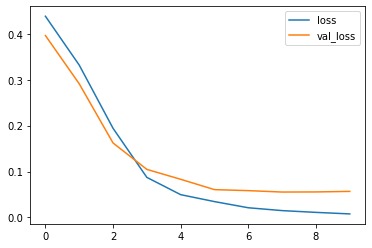

In [43]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend();

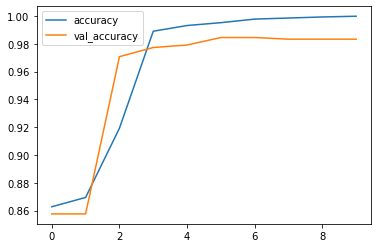

In [44]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend();

## Try with CNN

In [45]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [47]:
# create the model

# we get to choose embedding dimensionality
D = 20

i = Input(shape=(T,))

x = Embedding(V+1, D)(i)

x = Conv1D(32, 3, activation="relu")(x)
x = MaxPooling1D(3)(x)

x = Conv1D(64, 3, activation="relu")(x)
x = MaxPooling1D(3)(x)

x = Conv1D(128, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)

In [48]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [49]:
history = model.fit(data_train,
                    y_train,
                    epochs=10,
                    validation_data=(data_test, y_test))

Train on 3900 samples, validate on 1672 samples
Epoch 1/10
3900/3900 [==============================] - 16s 4ms/sample - loss: 0.3857 - accuracy: 0.8623 - val_loss: 0.2858 - val_accuracy: 0.8577
Epoch 2/10
3900/3900 [==============================] - 3s 851us/sample - loss: 0.1446 - accuracy: 0.9392 - val_loss: 0.0810 - val_accuracy: 0.9797
Epoch 3/10
3900/3900 [==============================] - 3s 880us/sample - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0618 - val_accuracy: 0.9839
Epoch 4/10
3900/3900 [==============================] - 3s 863us/sample - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0785 - val_accuracy: 0.9868
Epoch 5/10
3900/3900 [==============================] - 4s 916us/sample - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0728 - val_accuracy: 0.9874
Epoch 6/10
3900/3900 [==============================] - 3s 880us/sample - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0756 - val_accuracy: 0.9880
Epoch 7/10
3900/3900 [==============================] - 4s 907us/

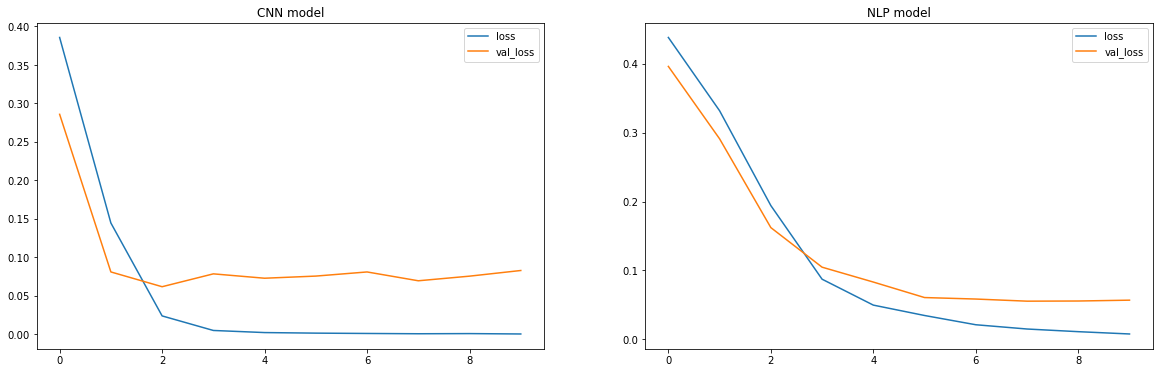

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

ax1.plot(history.history["loss"], label="loss")
ax1.plot(history.history["val_loss"], label="val_loss")
ax1.set_title("CNN model")
ax1.legend();

ax2.plot(r.history["loss"], label="loss")
ax2.plot(r.history["val_loss"], label="val_loss")
ax2.set_title("NLP model")
ax2.legend();

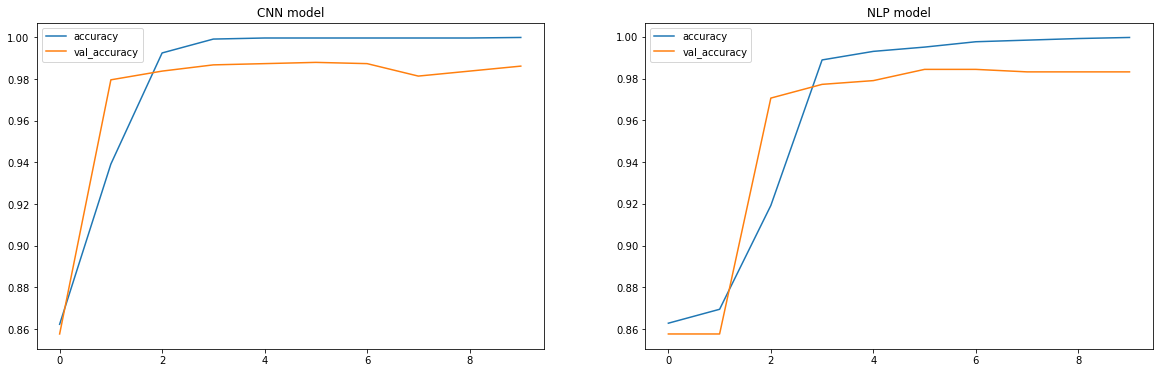

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

ax1.plot(history.history["accuracy"], label="accuracy")
ax1.plot(history.history["val_accuracy"], label="val_accuracy")
ax1.set_title("CNN model")
ax1.legend()

ax2.plot(r.history["accuracy"], label="accuracy")
ax2.plot(r.history["val_accuracy"], label="val_accuracy")
ax2.set_title("NLP model")
ax2.legend();